In [ ]:
import os
import random
import yaml
import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn
from ultralytics import YOLO
import matplotlib.pyplot as plt


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def get_image_files(folder):
    """Возвращает список файлов изображений (jpg/png и т.п.) из указанной папки."""
    return [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

train_images_folder = "train/images"
valid_images_folder = "valid/images"

train_images = get_image_files(train_images_folder)
valid_images = get_image_files(valid_images_folder)

all_images = []
for img in train_images:
    all_images.append(os.path.join(train_images_folder, img))
for img in valid_images:
    all_images.append(os.path.join(valid_images_folder, img))

print("Всего изображений (train + valid):", len(all_images))

random.shuffle(all_images)

# Разбиваем на k фолдов
k_folds = 5
fold_size = len(all_images) // k_folds
folds = []
for i in range(k_folds):
    start = i * fold_size
    end = start + fold_size
    if i == k_folds - 1:  # последний фолд берёт всё, что осталось
        end = len(all_images)
    folds.append(all_images[start:end])

def create_data_files_for_fold(fold_idx, folds, base_data_yaml="data.yaml"):
    """
    - Создаёт fold_{i}/train.txt и fold_{i}/val.txt с путями к изображениям
    - Создаёт fold_{i}/data_fold_{i}.yaml, где train=ABS_PATH(train.txt), val=ABS_PATH(val.txt)
    Возвращает (абсолютный) путь к созданному data_fold_{i}.yaml
    """
    fold_dir = f"fold_{fold_idx}"
    os.makedirs(fold_dir, exist_ok=True)

    # Текущий фолд - валидация
    val_images = folds[fold_idx]
    # Остальные фолды - тренировка
    train_images = []
    for j in range(k_folds):
        if j != fold_idx:
            train_images.extend(folds[j])

    train_txt_rel = os.path.join(fold_dir, "train.txt")
    val_txt_rel   = os.path.join(fold_dir, "val.txt")

    with open(train_txt_rel, "w") as f:
        for path in train_images:
            f.write(path + "\n")

    with open(val_txt_rel, "w") as f:
        for path in val_images:
            f.write(path + "\n")

    train_txt_abs = os.path.abspath(train_txt_rel)
    val_txt_abs   = os.path.abspath(val_txt_rel)

    with open(base_data_yaml, "r") as f:
        data = yaml.safe_load(f)

    data["train"] = train_txt_abs
    data["val"]   = val_txt_abs

    fold_data_yaml_rel = os.path.join(fold_dir, f"data_fold_{fold_idx}.yaml")
    with open(fold_data_yaml_rel, "w") as f:
        yaml.dump(data, f, default_flow_style=False)

    return os.path.abspath(fold_data_yaml_rel)


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Всего изображений (train + valid): 4320
Device: cuda


In [ ]:
base_model = "yolo12s.pt"
num_epochs = 25

all_results = [] 

for fold_idx in range(k_folds):
    print(f"\n=== Обучение на фолде {fold_idx+1} из {k_folds} ===")
    
    fold_data_yaml_abs = create_data_files_for_fold(fold_idx, folds, base_data_yaml="data.yaml")
    
    model = YOLO(base_model)

    model.train(
        data=fold_data_yaml_abs,
        epochs=num_epochs,
        imgsz=416,
        optimizer='AdamW',
        lr0=1e-3,
        project='YOLO12s_fold',
        name=f'fold_{fold_idx}',
        batch=32,
        device=device,
        seed=SEED 
    )

    results_csv_path = os.path.join('YOLO12s_fold', f'fold_{fold_idx}', 'results.csv')
    if os.path.exists(results_csv_path):
        df_results = pd.read_csv(results_csv_path)
        df_results["fold"] = fold_idx
        all_results.append(df_results)
    else:
        print(f"Файл {results_csv_path} не найден. Проверьте, что обучение для fold_{fold_idx} завершилось корректно.")


=== Обучение на фолде 1 из 5 ===
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
engine/trainer: task=detect, mode=train, model=yolo12s.pt, data=/home/user/CourseWork/Disease/fold_0/data_fold_0.yaml, epochs=25, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=YOLO12s_fold, name=fold_0, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fals

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1164.00it/s]

train: New cache created: train/labels.cache



val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1680.97it/s]


val: New cache created: train/labels.cache
Plotting labels to YOLO12s_fold/fold_0/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO12s_fold/fold_0
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.49G       1.22      2.115      1.478        134        416: 100%|██████████| 108/108 [00:19<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]

                   all        864       1930      0.409      0.511      0.486      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.47G      1.238      1.661      1.473        171        416: 100%|██████████| 108/108 [00:17<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]


                   all        864       1930      0.452      0.647      0.562      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.47G      1.174      1.533      1.435        142        416: 100%|██████████| 108/108 [00:16<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]


                   all        864       1930      0.616      0.525      0.576      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.46G      1.186      1.497       1.43        134        416: 100%|██████████| 108/108 [00:17<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]


                   all        864       1930      0.577      0.533       0.56      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.46G      1.146      1.426      1.406        134        416: 100%|██████████| 108/108 [00:16<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]


                   all        864       1930      0.569      0.639      0.608      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.47G      1.097      1.305      1.384        130        416: 100%|██████████| 108/108 [00:16<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]

                   all        864       1930      0.641      0.647      0.666       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.46G      1.054      1.227      1.352        126        416: 100%|██████████| 108/108 [00:17<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]

                   all        864       1930      0.779      0.701      0.763      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.47G       1.04      1.183      1.334        136        416: 100%|██████████| 108/108 [00:16<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]

                   all        864       1930      0.713      0.762      0.755      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.46G      1.013      1.141      1.321        156        416: 100%|██████████| 108/108 [00:16<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.31it/s]

                   all        864       1930      0.728      0.757      0.778      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.46G     0.9921      1.103      1.305        129        416: 100%|██████████| 108/108 [00:16<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]

                   all        864       1930      0.764      0.723      0.783      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.47G      0.961      1.038      1.288        130        416: 100%|██████████| 108/108 [00:16<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]

                   all        864       1930      0.803      0.713      0.803      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.47G     0.9467          1      1.274        132        416: 100%|██████████| 108/108 [00:16<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]

                   all        864       1930      0.843      0.782      0.842       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.42G     0.9474     0.9824      1.269        155        416: 100%|██████████| 108/108 [00:16<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]

                   all        864       1930      0.788      0.798      0.846      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.46G     0.9126     0.9514       1.25        138        416: 100%|██████████| 108/108 [00:16<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

                   all        864       1930      0.796      0.793      0.842      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.46G     0.8991     0.9294      1.241        111        416: 100%|██████████| 108/108 [00:16<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]

                   all        864       1930      0.836      0.815      0.865       0.66


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.45G     0.8155      0.827      1.205         67        416: 100%|██████████| 108/108 [00:17<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1930      0.831      0.777      0.857      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.45G     0.7934     0.7729      1.189         45        416: 100%|██████████| 108/108 [00:16<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

                   all        864       1930      0.834      0.828      0.866      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.45G     0.7729     0.7314      1.175         68        416: 100%|██████████| 108/108 [00:15<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1930      0.815      0.824      0.871      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.45G     0.7671     0.7015      1.173         65        416: 100%|██████████| 108/108 [00:15<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]

                   all        864       1930      0.857      0.835      0.887      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.46G     0.7401     0.6637      1.153         56        416: 100%|██████████| 108/108 [00:16<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]

                   all        864       1930      0.848      0.843      0.889       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.44G     0.7361     0.6403      1.151         77        416: 100%|██████████| 108/108 [00:16<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]

                   all        864       1930       0.86      0.854        0.9      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.46G     0.7052     0.6157       1.13         73        416: 100%|██████████| 108/108 [00:16<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]

                   all        864       1930      0.893      0.846      0.908      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.46G     0.6939     0.5857      1.126         60        416: 100%|██████████| 108/108 [00:16<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        864       1930      0.898      0.851      0.909      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.44G     0.6791     0.5624      1.116         72        416: 100%|██████████| 108/108 [00:16<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]

                   all        864       1930      0.872      0.879      0.912      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.45G     0.6641     0.5367      1.098         50        416: 100%|██████████| 108/108 [00:16<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        864       1930      0.868      0.891      0.916      0.748



25 epochs completed in 0.148 hours.
Optimizer stripped from YOLO12s_fold/fold_0/weights/last.pt, 18.9MB
Optimizer stripped from YOLO12s_fold/fold_0/weights/best.pt, 18.9MB

Validating YOLO12s_fold/fold_0/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv12s summary (fused): 159 layers, 9,235,524 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]


                   all        864       1930      0.869      0.891      0.916      0.748
Beans_Angular_LeafSpot         59        208      0.712      0.793      0.772      0.506
            Beans_Rust         92        448      0.785      0.829      0.878      0.671
Strawberry_Angular_LeafSpot         70         87      0.921      0.935      0.965      0.785
Strawberry_Anthracnose_Fruit_Rot         31         41      0.842      0.854      0.869      0.561
Strawberry_Blossom_Blight         53         83      0.906          1      0.967      0.843
  Strawberry_Gray_Mold         69         77      0.827      0.909      0.925      0.596
  Strawberry_Leaf_Spot         88        365      0.894      0.888      0.952      0.865
Strawberry_Powdery_Mildew_Fruit         38         89      0.861      0.843       0.91      0.714
Strawberry_Powdery_Mildew_Leaf         69        232      0.769       0.73       0.83      0.695
         Tomato_Blight         86         87      0.955      0.973      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1647.97it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1574.22it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO12s_fold/fold_1/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO12s_fold/fold_1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.66G      1.211      2.089      1.464        135        416: 100%|██████████| 108/108 [00:18<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]


                   all        864       1884      0.558      0.464      0.471      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.61G      1.229      1.683      1.468        176        416: 100%|██████████| 108/108 [00:17<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.00it/s]


                   all        864       1884      0.536      0.624      0.585      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.61G      1.178      1.537      1.425        117        416: 100%|██████████| 108/108 [00:16<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


                   all        864       1884      0.433      0.629      0.561      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       4.6G      1.189      1.519      1.432        134        416: 100%|██████████| 108/108 [00:16<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]


                   all        864       1884      0.473      0.633      0.546      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.59G       1.15      1.406       1.41        127        416: 100%|██████████| 108/108 [00:15<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        864       1884       0.61       0.63      0.654      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       4.6G      1.104      1.318      1.384        123        416: 100%|██████████| 108/108 [00:15<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]

                   all        864       1884      0.734      0.709      0.754      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.59G      1.067      1.252      1.357        113        416: 100%|██████████| 108/108 [00:16<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.23it/s]

                   all        864       1884       0.67      0.766      0.752       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       4.6G      1.055       1.21      1.347        132        416: 100%|██████████| 108/108 [00:15<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1884      0.761      0.766      0.805      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.58G      1.022      1.153      1.327        122        416: 100%|██████████| 108/108 [00:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1884      0.771      0.719      0.793      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.58G      1.009      1.096       1.31        148        416: 100%|██████████| 108/108 [00:16<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1884      0.757      0.796      0.832      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.59G     0.9648      1.043      1.291        158        416: 100%|██████████| 108/108 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]

                   all        864       1884      0.791      0.775      0.826      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       4.6G     0.9504      1.023      1.277        126        416: 100%|██████████| 108/108 [00:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]

                   all        864       1884      0.796       0.79      0.832      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       4.6G     0.9349       0.97      1.268        117        416: 100%|██████████| 108/108 [00:16<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        864       1884      0.835      0.815      0.863      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25       4.6G      0.917     0.9519      1.259        129        416: 100%|██████████| 108/108 [00:16<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1884      0.825       0.82      0.872      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.58G     0.9043     0.9176      1.246        122        416: 100%|██████████| 108/108 [00:16<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1884      0.807      0.821      0.865      0.669


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.58G     0.8258     0.8325      1.217         60        416: 100%|██████████| 108/108 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        864       1884      0.843      0.822      0.877      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.58G      0.803     0.7787      1.204         49        416: 100%|██████████| 108/108 [00:16<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        864       1884      0.842      0.835      0.882      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.57G     0.7751     0.7374      1.184         75        416: 100%|██████████| 108/108 [00:16<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]

                   all        864       1884      0.828      0.859      0.886      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.58G     0.7541     0.6896      1.167         64        416: 100%|██████████| 108/108 [00:16<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]

                   all        864       1884      0.851       0.86      0.903      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.58G     0.7429     0.6782       1.15         62        416: 100%|██████████| 108/108 [00:16<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]

                   all        864       1884      0.867      0.865      0.906      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.57G     0.7291     0.6451      1.151         69        416: 100%|██████████| 108/108 [00:16<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]

                   all        864       1884      0.912      0.844       0.91      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.59G      0.711     0.6095       1.13         67        416: 100%|██████████| 108/108 [00:16<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        864       1884      0.858      0.886      0.919      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.58G      0.699     0.5936      1.125         60        416: 100%|██████████| 108/108 [00:16<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1884      0.859      0.895      0.916      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.58G     0.6757     0.5619      1.109         67        416: 100%|██████████| 108/108 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]

                   all        864       1884      0.878      0.872      0.921      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.57G     0.6669     0.5387      1.098         64        416: 100%|██████████| 108/108 [00:16<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1884        0.9      0.866      0.925      0.775



25 epochs completed in 0.146 hours.
Optimizer stripped from YOLO12s_fold/fold_1/weights/last.pt, 18.9MB
Optimizer stripped from YOLO12s_fold/fold_1/weights/best.pt, 18.9MB

Validating YOLO12s_fold/fold_1/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv12s summary (fused): 159 layers, 9,235,524 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


                   all        864       1884      0.903      0.864      0.925      0.774
Beans_Angular_LeafSpot         88        280      0.821      0.737      0.827      0.559
            Beans_Rust         81        410      0.869      0.798      0.899       0.68
Strawberry_Angular_LeafSpot         69         89       0.95      0.921      0.963      0.815
Strawberry_Anthracnose_Fruit_Rot         26         45      0.811      0.571      0.787      0.562
Strawberry_Blossom_Blight         51         74      0.926          1      0.976      0.849
  Strawberry_Gray_Mold         83         86       0.94      0.965      0.981      0.756
  Strawberry_Leaf_Spot         90        330      0.937      0.827       0.95      0.854
Strawberry_Powdery_Mildew_Fruit         46        101      0.907      0.802      0.884      0.718
Strawberry_Powdery_Mildew_Leaf         68        206      0.759      0.797      0.869      0.723
         Tomato_Blight         86         87      0.948      0.989      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1647.12it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1539.96it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO12s_fold/fold_2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO12s_fold/fold_2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.66G      1.226      2.067      1.463        125        416: 100%|██████████| 108/108 [00:18<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.82it/s]


                   all        864       1795      0.382      0.502      0.385      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.61G      1.233      1.682      1.468        168        416: 100%|██████████| 108/108 [00:17<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.23it/s]


                   all        864       1795      0.497      0.608      0.571      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.47G      1.184      1.508      1.439        145        416: 100%|██████████| 108/108 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]


                   all        864       1795      0.453      0.534      0.506      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.47G       1.19      1.492      1.445        128        416: 100%|██████████| 108/108 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]


                   all        864       1795      0.552      0.635      0.631      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.61G      1.159       1.41      1.415        127        416: 100%|██████████| 108/108 [00:16<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


                   all        864       1795      0.509      0.541      0.512      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.49G      1.113      1.309      1.395        140        416: 100%|██████████| 108/108 [00:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        864       1795      0.689      0.681      0.727      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.47G      1.067      1.236      1.363        113        416: 100%|██████████| 108/108 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1795      0.731      0.733      0.787      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.47G      1.057      1.214      1.356        127        416: 100%|██████████| 108/108 [00:17<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]

                   all        864       1795      0.778      0.739      0.795      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.47G      1.021      1.127      1.326        143        416: 100%|██████████| 108/108 [00:16<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        864       1795      0.718      0.733      0.775       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.48G      1.008       1.09      1.321        131        416: 100%|██████████| 108/108 [00:16<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]

                   all        864       1795      0.752      0.775       0.81      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.49G     0.9797      1.064      1.311        153        416: 100%|██████████| 108/108 [00:16<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1795      0.788      0.807      0.832      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.47G     0.9538      1.006      1.287        137        416: 100%|██████████| 108/108 [00:16<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        864       1795      0.791      0.788      0.843      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.48G     0.9484     0.9962      1.286        147        416: 100%|██████████| 108/108 [00:17<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.27it/s]

                   all        864       1795      0.826      0.797      0.849      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.49G     0.9318     0.9375      1.269        124        416: 100%|██████████| 108/108 [00:16<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1795      0.809        0.8      0.859      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.49G     0.9139     0.9135      1.256        118        416: 100%|██████████| 108/108 [00:17<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.21it/s]

                   all        864       1795      0.833      0.805      0.859      0.668


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.49G      0.826     0.8212      1.241         61        416: 100%|██████████| 108/108 [00:18<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.26it/s]

                   all        864       1795      0.846       0.84       0.88      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.46G     0.8091     0.7731      1.225         53        416: 100%|██████████| 108/108 [00:16<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1795       0.83      0.849      0.896      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.47G     0.7909     0.7384       1.21         76        416: 100%|██████████| 108/108 [00:16<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        864       1795      0.849      0.854      0.897      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.45G     0.7683      0.704      1.197         58        416: 100%|██████████| 108/108 [00:15<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        864       1795      0.856      0.846        0.9      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.47G     0.7456     0.6578      1.177         46        416: 100%|██████████| 108/108 [00:15<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

                   all        864       1795      0.839      0.881      0.906      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.46G     0.7331     0.6355      1.166         88        416: 100%|██████████| 108/108 [00:16<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        864       1795      0.864      0.869       0.91      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.47G     0.7117     0.6166      1.152         70        416: 100%|██████████| 108/108 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]

                   all        864       1795      0.866      0.881      0.918      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.47G     0.6983      0.602      1.144         55        416: 100%|██████████| 108/108 [00:16<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        864       1795      0.882      0.878      0.921      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.47G     0.6876     0.5722      1.132         81        416: 100%|██████████| 108/108 [00:16<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        864       1795      0.869      0.893      0.922      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.47G     0.6749     0.5528      1.118         61        416: 100%|██████████| 108/108 [00:16<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        864       1795      0.897      0.868       0.92      0.764



25 epochs completed in 0.149 hours.
Optimizer stripped from YOLO12s_fold/fold_2/weights/last.pt, 18.9MB
Optimizer stripped from YOLO12s_fold/fold_2/weights/best.pt, 18.9MB

Validating YOLO12s_fold/fold_2/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv12s summary (fused): 159 layers, 9,235,524 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]


                   all        864       1795      0.897      0.868       0.92      0.764
Beans_Angular_LeafSpot         71        235      0.855      0.719      0.838       0.54
            Beans_Rust         83        383      0.842      0.841       0.91      0.696
Strawberry_Angular_LeafSpot         69         84      0.917      0.857      0.924      0.757
Strawberry_Anthracnose_Fruit_Rot         28         45       0.88      0.844      0.887      0.629
Strawberry_Blossom_Blight         72        102      0.939       0.99      0.986      0.879
  Strawberry_Gray_Mold         91         98      0.945      0.874      0.938      0.659
  Strawberry_Leaf_Spot         86        273      0.918      0.934      0.975      0.919
Strawberry_Powdery_Mildew_Fruit         35         75      0.786      0.587      0.771      0.548
Strawberry_Powdery_Mildew_Leaf         77        245      0.722      0.792      0.839      0.714
         Tomato_Blight         82         82      0.998          1      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:01<00:00, 1902.55it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1608.24it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO12s_fold/fold_3/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO12s_fold/fold_3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.54G      1.228      2.101      1.475        138        416: 100%|██████████| 108/108 [00:18<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]


                   all        864       1994      0.408      0.489        0.4      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       4.5G      1.223      1.681      1.463        158        416: 100%|██████████| 108/108 [00:17<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]


                   all        864       1994      0.511      0.572       0.56       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.49G      1.184      1.545      1.432        142        416: 100%|██████████| 108/108 [00:16<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.08it/s]


                   all        864       1994      0.502        0.5      0.434      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.47G       1.18      1.513      1.426        120        416: 100%|██████████| 108/108 [00:16<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]


                   all        864       1994      0.585      0.605      0.604      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.47G      1.132      1.414      1.398        131        416: 100%|██████████| 108/108 [00:15<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]


                   all        864       1994      0.604      0.719      0.718      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.49G      1.091      1.311      1.375        127        416: 100%|██████████| 108/108 [00:17<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.23it/s]


                   all        864       1994      0.634      0.624      0.659      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.49G      1.055      1.256      1.353        124        416: 100%|██████████| 108/108 [00:16<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]

                   all        864       1994      0.688      0.695      0.736      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.62G      1.038      1.188      1.336        128        416: 100%|██████████| 108/108 [00:16<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]

                   all        864       1994       0.71       0.75      0.776      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.49G      1.025      1.142      1.327        143        416: 100%|██████████| 108/108 [00:16<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]

                   all        864       1994      0.672      0.731      0.741      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.49G     0.9981      1.105      1.315        156        416: 100%|██████████| 108/108 [00:16<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.26it/s]

                   all        864       1994      0.783      0.788      0.823       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       4.5G     0.9706      1.057      1.293        129        416: 100%|██████████| 108/108 [00:17<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        864       1994      0.789      0.816      0.844      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.48G     0.9529      1.002      1.276        134        416: 100%|██████████| 108/108 [00:17<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.26it/s]

                   all        864       1994      0.792       0.81      0.836      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       4.5G     0.9424     0.9994      1.273        124        416: 100%|██████████| 108/108 [00:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]

                   all        864       1994      0.823      0.794      0.863       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.47G     0.9208     0.9536      1.255        144        416: 100%|██████████| 108/108 [00:16<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]

                   all        864       1994      0.802      0.804      0.841       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       4.5G     0.9033     0.9343      1.249        123        416: 100%|██████████| 108/108 [00:16<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        864       1994      0.822      0.815      0.861      0.672


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.49G     0.8219     0.8271       1.22         65        416: 100%|██████████| 108/108 [00:17<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1994      0.836      0.831      0.884      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.47G     0.7936     0.7752      1.202         60        416: 100%|██████████| 108/108 [00:17<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]

                   all        864       1994       0.83      0.838      0.877      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.49G     0.7739     0.7674      1.192         58        416: 100%|██████████| 108/108 [00:17<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

                   all        864       1994      0.874      0.813      0.892      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.47G     0.7572     0.7139      1.173         71        416: 100%|██████████| 108/108 [00:16<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.26it/s]

                   all        864       1994      0.878      0.834      0.902       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.49G     0.7351     0.6617      1.152         61        416: 100%|██████████| 108/108 [00:16<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]

                   all        864       1994      0.886      0.842      0.907      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.47G     0.7325     0.6501      1.153         72        416: 100%|██████████| 108/108 [00:16<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        864       1994      0.889      0.854      0.905      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.49G     0.7051     0.6091      1.129         72        416: 100%|██████████| 108/108 [00:17<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]

                   all        864       1994      0.885      0.868      0.918      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.47G     0.6858     0.5849      1.122         60        416: 100%|██████████| 108/108 [00:16<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        864       1994      0.891      0.869      0.919      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.47G     0.6662      0.564      1.103         55        416: 100%|██████████| 108/108 [00:16<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1994      0.887      0.884      0.921      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.47G      0.655      0.542      1.095         63        416: 100%|██████████| 108/108 [00:16<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]

                   all        864       1994      0.883      0.888      0.924      0.766



25 epochs completed in 0.149 hours.
Optimizer stripped from YOLO12s_fold/fold_3/weights/last.pt, 18.9MB
Optimizer stripped from YOLO12s_fold/fold_3/weights/best.pt, 18.9MB

Validating YOLO12s_fold/fold_3/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv12s summary (fused): 159 layers, 9,235,524 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


                   all        864       1994      0.883      0.889      0.924      0.766
Beans_Angular_LeafSpot         78        272      0.781      0.757       0.78      0.504
            Beans_Rust         91        476      0.856      0.796        0.9       0.69
Strawberry_Angular_LeafSpot         66         75      0.984      0.907      0.985      0.834
Strawberry_Anthracnose_Fruit_Rot         34         59       0.78      0.729      0.794      0.521
Strawberry_Blossom_Blight         58         83       0.91          1      0.987      0.851
  Strawberry_Gray_Mold         67         68       0.88      0.973      0.969       0.72
  Strawberry_Leaf_Spot         91        335      0.926      0.919      0.969      0.886
Strawberry_Powdery_Mildew_Fruit         42         85      0.825      0.832      0.915      0.725
Strawberry_Powdery_Mildew_Leaf         78        280      0.702      0.761      0.811      0.679
         Tomato_Blight         93         93      0.967          1      0.9

train: Scanning train/labels... 3456 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3456/3456 [00:02<00:00, 1656.89it/s]


train: New cache created: train/labels.cache


val: Scanning train/labels... 864 images, 0 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<00:00, 1534.09it/s]

val: New cache created: train/labels.cache


Plotting labels to YOLO12s_fold/fold_4/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to YOLO12s_fold/fold_4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.54G      1.218      2.128      1.497        124        416: 100%|██████████| 108/108 [00:18<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.23it/s]


                   all        864       1886      0.404      0.499      0.426      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.63G      1.226      1.699      1.491        171        416: 100%|██████████| 108/108 [00:17<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


                   all        864       1886      0.577       0.51      0.528      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25       4.5G      1.183      1.515      1.455        134        416: 100%|██████████| 108/108 [00:16<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


                   all        864       1886      0.499      0.611      0.564      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.49G      1.182      1.508      1.457        139        416: 100%|██████████| 108/108 [00:16<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1886       0.64      0.658      0.649      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.49G      1.136      1.424      1.432        131        416: 100%|██████████| 108/108 [00:16<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]


                   all        864       1886      0.608      0.675      0.669      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.49G       1.09      1.303      1.406        133        416: 100%|██████████| 108/108 [00:16<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]

                   all        864       1886      0.681      0.697      0.733      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.49G      1.069      1.237      1.389        118        416: 100%|██████████| 108/108 [00:16<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1886      0.728      0.692      0.726      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25       4.5G       1.03      1.197      1.365        115        416: 100%|██████████| 108/108 [00:16<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]

                   all        864       1886      0.726       0.76      0.783      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.48G      1.007      1.158      1.351        154        416: 100%|██████████| 108/108 [00:16<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]

                   all        864       1886      0.691      0.761       0.79      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.48G     0.9942      1.124      1.337        142        416: 100%|██████████| 108/108 [00:16<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        864       1886      0.807      0.788      0.825      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25       4.5G     0.9825      1.064      1.332        150        416: 100%|██████████| 108/108 [00:16<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1886      0.815       0.76      0.813      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.48G     0.9599      1.021      1.307        131        416: 100%|██████████| 108/108 [00:16<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]

                   all        864       1886      0.808      0.785      0.831      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25       4.5G      0.936     0.9781      1.293        133        416: 100%|██████████| 108/108 [00:16<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]

                   all        864       1886      0.811      0.806      0.852      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.49G     0.9155     0.9548      1.275        127        416: 100%|██████████| 108/108 [00:16<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        864       1886      0.798      0.803      0.853       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.48G     0.9112     0.9347      1.273        132        416: 100%|██████████| 108/108 [00:16<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        864       1886      0.825      0.816      0.856       0.66


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.49G     0.8268     0.8303      1.261         71        416: 100%|██████████| 108/108 [00:17<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        864       1886      0.857      0.813      0.872      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.49G     0.8014     0.7854      1.242         55        416: 100%|██████████| 108/108 [00:16<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        864       1886      0.817      0.821      0.866      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.47G     0.7741     0.7388      1.228         63        416: 100%|██████████| 108/108 [00:16<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

                   all        864       1886      0.858      0.838      0.889        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.48G     0.7694     0.6926      1.215         60        416: 100%|██████████| 108/108 [00:16<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1886      0.858      0.843      0.891      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.48G     0.7428     0.6764       1.19         57        416: 100%|██████████| 108/108 [00:16<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        864       1886      0.865      0.844      0.901      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.47G     0.7297       0.64      1.181         75        416: 100%|██████████| 108/108 [00:16<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]

                   all        864       1886      0.865       0.85      0.898      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.47G      0.711     0.6224      1.169         59        416: 100%|██████████| 108/108 [00:16<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]


                   all        864       1886      0.884      0.868      0.909      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.47G     0.6915     0.5959      1.155         57        416: 100%|██████████| 108/108 [00:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

                   all        864       1886      0.881      0.883       0.92      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.47G     0.6787     0.5617      1.149         66        416: 100%|██████████| 108/108 [00:16<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

                   all        864       1886       0.87      0.879      0.919      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.49G      0.662     0.5484      1.131         79        416: 100%|██████████| 108/108 [00:16<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]

                   all        864       1886      0.866      0.884       0.92       0.76



25 epochs completed in 0.147 hours.
Optimizer stripped from YOLO12s_fold/fold_4/weights/last.pt, 18.9MB
Optimizer stripped from YOLO12s_fold/fold_4/weights/best.pt, 18.9MB

Validating YOLO12s_fold/fold_4/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24252MiB)
YOLOv12s summary (fused): 159 layers, 9,235,524 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


                   all        864       1886      0.866      0.884       0.92       0.76
Beans_Angular_LeafSpot         74        238      0.744      0.756      0.795       0.51
            Beans_Rust         77        398      0.804      0.843      0.883      0.637
Strawberry_Angular_LeafSpot         70         84      0.838      0.863      0.942      0.769
Strawberry_Anthracnose_Fruit_Rot         39         61      0.799      0.784      0.896       0.59
Strawberry_Blossom_Blight         53         77      0.881          1      0.974      0.853
  Strawberry_Gray_Mold         72         78      0.914       0.91      0.934      0.671
  Strawberry_Leaf_Spot         82        297      0.856      0.924      0.951      0.869
Strawberry_Powdery_Mildew_Fruit         43         79      0.748      0.797      0.792       0.62
Strawberry_Powdery_Mildew_Leaf         74        290      0.855      0.783      0.913        0.8
         Tomato_Blight        102        103       0.99      0.989      0.9

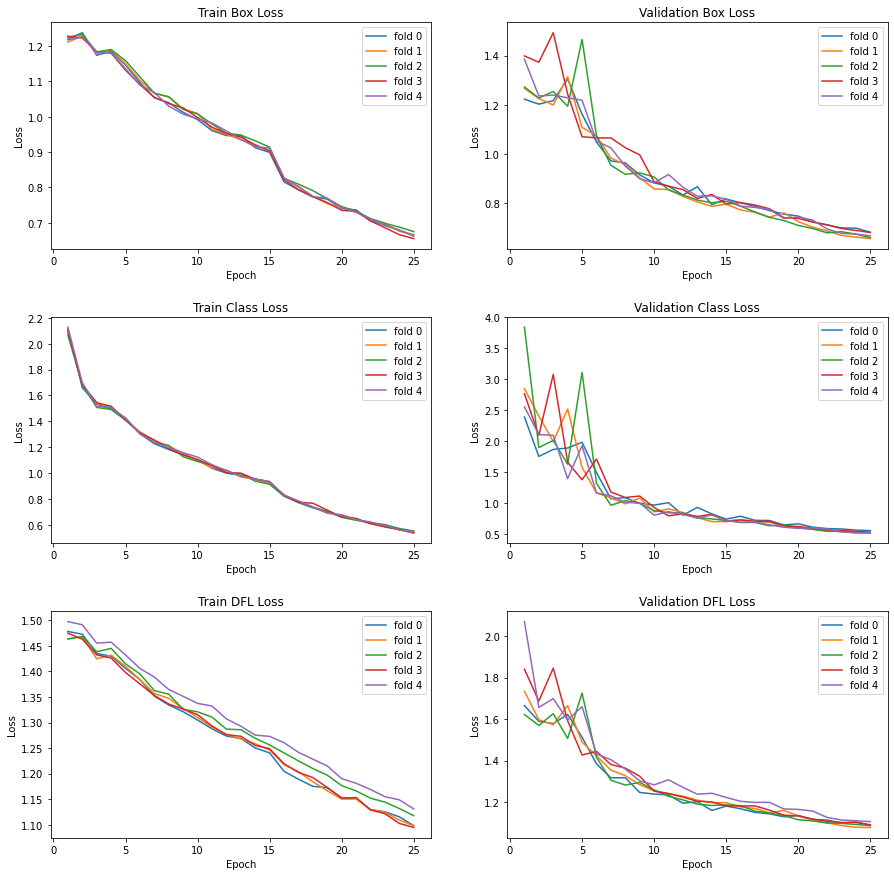

In [ ]:
df_all = pd.concat(all_results, ignore_index=True)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3)

metrics = [
    ('train/box_loss', 'Train Box Loss'),
    ('val/box_loss', 'Validation Box Loss'),
    ('train/cls_loss', 'Train Class Loss'),
    ('val/cls_loss', 'Validation Class Loss'),
    ('train/dfl_loss', 'Train DFL Loss'),
    ('val/dfl_loss', 'Validation DFL Loss')
]

for ax, (metric_col, metric_name) in zip(axes.flat, metrics):
    for f_id in range(k_folds):
        df_fold = df_all[df_all["fold"] == f_id]
        ax.plot(df_fold['epoch'], df_fold[metric_col], label=f'fold {f_id}')
    ax.set_title(metric_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

plt.show()

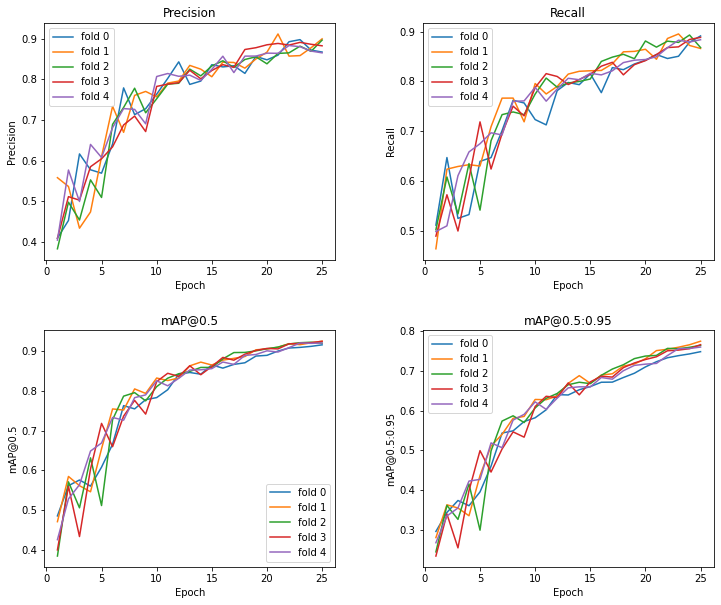

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

fig.subplots_adjust(hspace=0.3, wspace=0.3)

metrics = [
    ('metrics/precision(B)',   'Precision'),
    ('metrics/recall(B)',      'Recall'),
    ('metrics/mAP50(B)',       'mAP@0.5'),
    ('metrics/mAP50-95(B)',    'mAP@0.5:0.95')
]

for ax, (metric_col, metric_title) in zip(axes.flat, metrics):
    for fold_id in sorted(df_all['fold'].unique()):
        df_fold = df_all[df_all['fold'] == fold_id]
        ax.plot(df_fold['epoch'], df_fold[metric_col], label=f'fold {fold_id}')
    ax.set_title(metric_title)
    ax.set_ylabel(metric_title)
    ax.set_xlabel('Epoch')
    ax.legend()

plt.show()